## 5.3.1 특성 추출 

### 5-16 VGG16 합성곱 기반 층 만들기 

In [1]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))

Using TensorFlow backend.


In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

#### 데이터 증식을 사용하지 않는 빠른 특성 추출 

### 5-17 사전 훈련된 합성곱 기반 층을 사용한 특성 추출하기 

In [3]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './datasets/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [4]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

### 5-18 완전 연결 분류기를 정의하고 훈련하기 

In [5]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels,
                   epochs=30,
                   batch_size=20,
                   validation_data=(validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s 490us/step - loss: 0.5898 - acc: 0.6875 - val_loss: 0.4515 - val_acc: 0.8280
Epoch 2/30
2000/2000 [==============================] - 1s 269us/step - loss: 0.4280 - acc: 0.8110 - val_loss: 0.3679 - val_acc: 0.8520
Epoch 3/30
2000/2000 [==============================] - 1s 262us/step - loss: 0.3571 - acc: 0.8485 - val_loss: 0.3272 - val_acc: 0.8740
Epoch 4/30
2000/2000 [==============================] - 1s 261us/step - loss: 0.3229 - acc: 0.8585 - val_loss: 0.3035 - val_acc: 0.8830
Epoch 5/30
2000/2000 [==============================] - 1s 263us/step - loss: 0.2902 - acc: 0.8820 - val_loss: 0.2876 - val_acc: 0.8880
Epoch 6/30
2000/2000 [==============================] - 1s 261us/step - loss: 0.2647 - acc: 0.9015 - val_loss: 0.2750 - val_acc: 0.8910
Epoch 7/30
2000/2000 [==============================] - 1s 267us/step - loss: 0.2558 - acc: 0.9035 - val_loss: 0.2833 - val_acc: 0.8810


### 5-19 결과 그래프 그리기 

In [6]:
%matplotlib inline

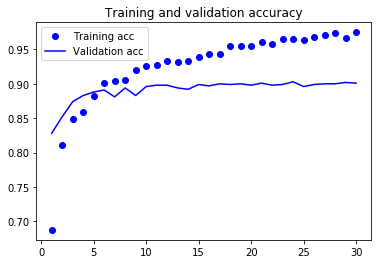

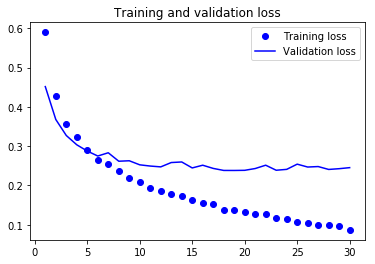

In [7]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### 데이터 증식을 사용한 특성 추출 

### 5-20 합성곱 기반 층 위에 완전 연결 분류기 추가하기 

In [8]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [9]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [10]:
print('conv_base를 동결하기 전 훈련되는 가중치의 수:',
     len(model.trainable_weights))
conv_base.trainable=False
print('conv_base를 동결한 후 훈련되는 가중치의 수:',
     len(model.trainable_weights))

conv_base를 동결하기 전 훈련되는 가중치의 수: 30
conv_base를 동결한 후 훈련되는 가중치의 수: 4


### 5-21 동결된 합성곱 기반 층과 함께 모델을 엔드-투-엔드로 훈련하기 

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=2e-5),
             metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
 - 13s - loss: 0.6075 - acc: 0.6755 - val_loss: 0.4573 - val_acc: 0.8310
Epoch 2/30
 - 12s - loss: 0.4804 - acc: 0.7875 - val_loss: 0.3885 - val_acc: 0.8280
Epoch 3/30
 - 12s - loss: 0.4413 - acc: 0.7935 - val_loss: 0.3381 - val_acc: 0.8740
Epoch 4/30
 - 12s - loss: 0.4044 - acc: 0.8240 - val_loss: 0.3223 - val_acc: 0.8720
Epoch 5/30
 - 12s - loss: 0.3906 - acc: 0.8255 - val_loss: 0.2981 - val_acc: 0.8840
Epoch 6/30
 - 12s - loss: 0.3696 - acc: 0.8310 - val_loss: 0.2876 - val_acc: 0.8880
Epoch 7/30
 - 12s - loss: 0.3572 - acc: 0.8405 - val_loss: 0.2784 - val_acc: 0.8910
Epoch 8/30
 - 12s - loss: 0.3460 - acc: 0.8515 - val_loss: 0.2769 - val_acc: 0.8900
Epoch 9/30
 - 12s - loss: 0.3376 - acc: 0.8525 - val_loss: 0.2719 - val_acc: 0.8900
Epoch 10/30
 - 12s - loss: 0.3415 - acc: 0.8520 - val_loss: 0.2654 - val_acc: 0.8930
Epoch 11/30
 - 12s - loss: 0.3354 - acc: 0.8570 - val_loss: 0.2741 - val_ac

## 5.3.2 미세 조정 

### 5-22 특정 층까지 모든 층 동결하기 

In [12]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else :
        layer.trainable = False

### 5-23 모델 미세 조정하기

In [13]:
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-5),
             metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50)

Epoch 1/100
100/100 [==============================] - 13s 134ms/step - loss: 0.3015 - acc: 0.8665 - val_loss: 0.2271 - val_acc: 0.9080
Epoch 2/100
100/100 [==============================] - 12s 120ms/step - loss: 0.2638 - acc: 0.8835 - val_loss: 0.2007 - val_acc: 0.9180
Epoch 3/100
100/100 [==============================] - 12s 121ms/step - loss: 0.2145 - acc: 0.9095 - val_loss: 0.2274 - val_acc: 0.9130
Epoch 4/100
100/100 [==============================] - 12s 121ms/step - loss: 0.2211 - acc: 0.9050 - val_loss: 0.1976 - val_acc: 0.9220
Epoch 5/100
100/100 [==============================] - 12s 121ms/step - loss: 0.2046 - acc: 0.9095 - val_loss: 0.1948 - val_acc: 0.9210
Epoch 6/100
100/100 [==============================] - 12s 123ms/step - loss: 0.1973 - acc: 0.9220 - val_loss: 0.1935 - val_acc: 0.9260
Epoch 7/100
100/100 [==============================] - 12s 122ms/step - loss: 0.1825 - acc: 0.9260 - val_loss: 0.1969 - val_acc: 0.9210
Epoch 8/100
100/100 [===========================

Epoch 61/100
100/100 [==============================] - 12s 121ms/step - loss: 0.0417 - acc: 0.9865 - val_loss: 0.3434 - val_acc: 0.9250
Epoch 62/100
100/100 [==============================] - 12s 122ms/step - loss: 0.0325 - acc: 0.9885 - val_loss: 0.2204 - val_acc: 0.9370
Epoch 63/100
100/100 [==============================] - 12s 121ms/step - loss: 0.0309 - acc: 0.9885 - val_loss: 0.2800 - val_acc: 0.9400
Epoch 64/100
100/100 [==============================] - 12s 122ms/step - loss: 0.0330 - acc: 0.9865 - val_loss: 0.2367 - val_acc: 0.9370
Epoch 65/100
100/100 [==============================] - 12s 121ms/step - loss: 0.0307 - acc: 0.9880 - val_loss: 0.2432 - val_acc: 0.9360
Epoch 66/100
100/100 [==============================] - 12s 121ms/step - loss: 0.0306 - acc: 0.9890 - val_loss: 0.2113 - val_acc: 0.9410
Epoch 67/100
100/100 [==============================] - 12s 122ms/step - loss: 0.0271 - acc: 0.9910 - val_loss: 0.2162 - val_acc: 0.9430
Epoch 68/100
100/100 [===================

### 5-24 부드러운 그래프 그리기 

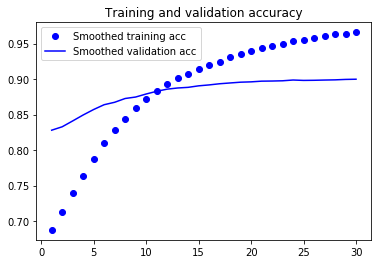

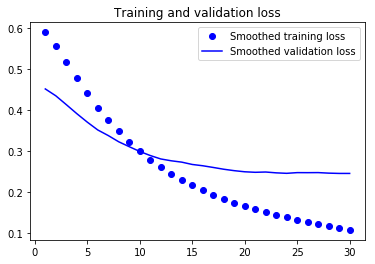

In [14]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else :
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 1000 images belonging to 2 classes.
test acc: 0.9419999885559082
